# Image Categorization

Data set from:
[ http://www.cs.utoronto.ca/%7Ekriz/cifar.html ], 
Learning Multiple Layers of Features from Tiny Images, Alex Krizhevsky, 2009.

Tutorial from  [ https://medium.com/towards-artificial-intelligence/image-classification-using-deep-learning-pytorch-a-case-study-with-flower-image-data-80a18554df63 ]

### ✨TODO
 - include nn.Dropout layer
 - use CUDA

In [1]:
import os
import time
import numpy as np

import matplotlib.pyplot as mp
import matplotlib.image as mpimg

import tarfile, pickle

import torch
import torch.nn as nn
import torch.nn.functional as F

torch.set_printoptions(linewidth = 270)
torch.set_printoptions(threshold=10000)

## 0. Helper Methods

In [2]:
def unpickle(file):   
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

def make_img_subset(dat, lab=None) :
    
    fig = mp.figure(figsize=(10,10))
    
    for i in range(1, 5 * 5 + 1) : 
        
        record = np.random.randint(len(dat))
        img = dat[record]
        
        ax = fig.add_subplot(5,5, i)

        ax.axis('off')
        fig.tight_layout()
              
        if lab is not None :
            ax.set_title('img[' + str(record) + '] cat:' + str(lab[record].item()))

        mp.imshow(img)
    
def make_img_tensor(out) : 
    
    out = out[:3].detach()
    
    fig = mp.figure(figsize=(20, 40))
    
    k = 1

    for i in out : 
        ax = fig.add_subplot(out.shape[0], out.shape[3], k)

        ax.set_title('img:' + str(k))

        mp.imshow(i)
        k += 1

def img_tensor_chan(out, batten) : 
    out = out.detach().numpy()
    batten = batten.detach().transpose(1,2).transpose(2,3)
    fig = mp.figure(figsize=(40, 10))
    k = 1
    oidx = 0
    for i in out : 
        
        ax = fig.add_subplot(out.shape[0], out.shape[1] + 1, k)
        mp.imshow(batten[oidx])
        k += 1
        for j in i :
            ax = fig.add_subplot(out.shape[0], out.shape[1] + 1, k)
            ax.set_title('img:' + str(k-1))
#             ax.axis('off')
            fig.tight_layout()
            mp.imshow(j)
            k += 1
        oidx += 1

## 1. Get

Download files into current directory.

In [3]:
# extract
tar = tarfile.open("cifar-10-python.tar.gz")
#extract
tar.extractall('.')
tar.close()
print("files extracted.")

files extracted.


### 1.1. Data usage example

In [4]:
# unpickle for use
example_set = unpickle(os.path.join("./cifar-10-batches-py/data_batch_1"))

# get labels
example_train_lables = torch.tensor(example_set[b'labels'])
print('example labels (cats):', example_train_lables.unique())

# get img data
example_data = torch.tensor(example_set[b'data'])
print('example data shape:', example_data.shape)

#scale 255 ints to (0,1) floats
example_train_data = example_data.float() / 255.

# reshape to 3x32x32
example_train_data = example_train_data.reshape((10000, 3, 32, 32))
print('example tensor shape', example_train_data.shape)

example labels (cats): tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
example data shape: torch.Size([10000, 3072])
example tensor shape torch.Size([10000, 3, 32, 32])


### 1.2. Sample
To verify that the data was unpacked and folded correctly, transpose the `example_train_data` so that the three rgb channels are indexed last then plot a rand sampling of the image data.

bat pixels torch.Size([10000, 32, 32, 3])


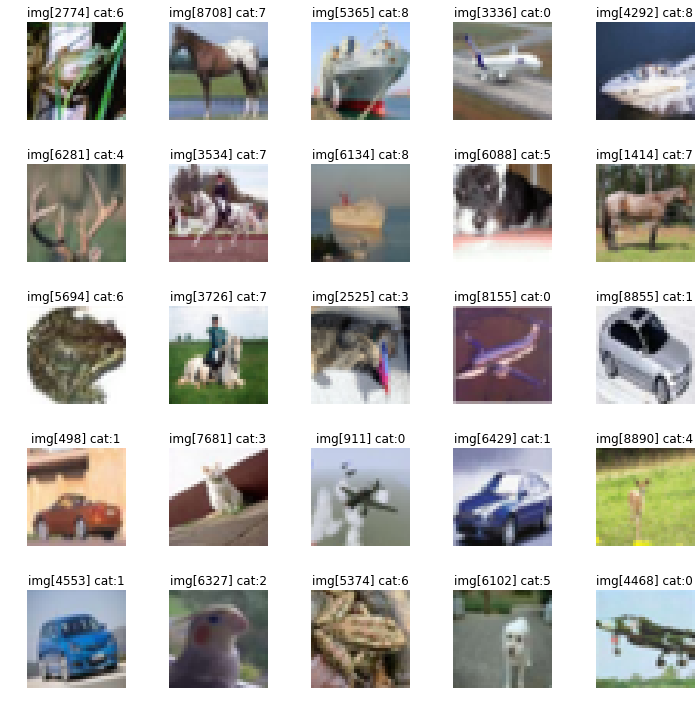

In [5]:
example_pixels = example_train_data.transpose(1,2).transpose(2,3)

print('bat pixels', example_pixels.shape)   
make_img_subset(example_pixels, example_train_lables)

### 1.3 Lookup 👓

If your are interested in viewing a specific image, specify image index with `lookup`.

lookup image: 31 b'trucking_rig_s_001402.png' 9


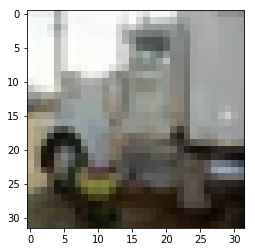

In [6]:
#image number to investigate
lookup = 31
print('lookup image:', str(lookup) , example_set[b'filenames'][lookup], example_set[b'labels'][lookup] )
mp.imshow(example_pixels[lookup])

# 2. Neural Network Dense Block Model

( Conv-Dense-Conv-MPool-Dense-Conv-MPool-Flatten-Lin-LinCat )

Here, a dense block module is defined. 
The referenced tutorial is listed below. 
Following it, the Image Categorization neural network model is described. 
In it, two dense blocks are used with convolution and max pool layers between them to reduce the mapping size, followed by fully connected linear layers to generate the categorical output.

[ https://towardsdatascience.com/simple-implementation-of-densely-connected-convolutional-networks-in-pytorch-3846978f2f36 ]

In [7]:
class denseblock(nn.Module) :
    def __init__(self, in_chan, out_chan) :
        super(denseblock, self).__init__()
        
        self.rel = nn.ReLU()
        
        self.conv1 = nn.Conv2d(in_channels=in_chan * 1, out_channels=out_chan, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=in_chan * 1, out_channels=out_chan, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=in_chan * 2, out_channels=out_chan, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(in_channels=in_chan * 3, out_channels=out_chan, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(in_channels=in_chan * 4, out_channels=out_chan, kernel_size=3, stride=1, padding=1)
        
    def forward(self, dat, verbose=False) :
               
        conv1 = self.rel(self.conv1(dat))
        
        conv2 = self.rel(self.conv2(conv1))
        into3 = self.rel(torch.cat([conv1, conv2], 1))
        
        conv3 = self.rel(self.conv3(into3))
        into4 = self.rel(torch.cat([conv1, conv2, conv3], 1))
        
        conv4 = self.rel(self.conv4(into4))
        into5 = self.rel(torch.cat([conv1, conv2, conv3, conv4],1))
        
        conv5 = self.rel(self.conv5(into5))
        
        
        return self.rel(torch.cat([conv1, conv2, conv3, conv4, conv5], 1))
#         return conv5
    
    

class imgcatdense(nn.Module) :
    def __init__(self) :
        super(imgcatdense, self).__init__()
        
        self.conin = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=(3, 3), stride=1, padding=(1,1))

        self.dens3_15 = denseblock(3,3)        
        
        self.mpool = nn.MaxPool2d(kernel_size=(2,2))
      
        # self.drp25 = nn.Dropout(0.25)
        
        self.rel = nn.ReLU()      

        self.dens15_75 = denseblock(15,15)
        
        self.lin = nn.Linear(in_features=2700, out_features=30)
        
        self.cat = nn.Linear(in_features=30, out_features=10)


        #verify
        print('created nerual net:\n', self)
#         for j in self.parameters() : print(j)
        print('---')
    
    def forward(self, dat, verbose=False) :
        
        if verbose : print('in', dat.shape)
                 
        out = self.conin(dat)
        if verbose : print('conin.shape:', out.shape, '-- see images below'); img_tensor_chan(out[0:1], dat[0:1]);
                        
                
        out = self.dens3_15(out, True)
        if verbose : print('dense3_3:', out.shape, '-- see images below'); img_tensor_chan(out[0:1], dat[0:1]);
        
        
        out = nn.Conv2d(in_channels=15, out_channels=15, kernel_size=(3, 3))(out)
        if verbose : print('conv-inline:', out.shape, '-- see images below'); img_tensor_chan(out[0:1], dat[0:1]);
        
        out = self.mpool(out)
        if verbose : print('mpool:', out.shape, '-- see images below'); img_tensor_chan(out[0:1], dat[0:1]);
            
            
        out = self.dens15_75(out, True)
        if verbose : print('dense15_75:', out.shape); # img_tensor_chan(out[0:1,0:15], dat[0:1,0:15]);
            
            
        out = nn.Conv2d(in_channels=75, out_channels=75, kernel_size=(3, 3))(out)
        if verbose : print('conv-inline:', out.shape)
            
        out = self.mpool(out)
        if verbose : print('mpool:', out.shape)

        
        out = torch.flatten(out,1)
        if verbose : print('torch.flatten:', out.shape)
        
        out = self.lin(out)
        if verbose : print('lin:', out.shape)
            
        out = self.cat(out)
        if verbose : print('cat:', out.shape)
       
        return out

## 2.1 Usage Example

An instance of the Image Categorization neural network is defined.
The displayed description was specified to be called at initialization.
The model (only) is saved, for usage later (if necessary).

A slice of the training data is used to illustrate the result of some of the layers of the neural network.
It can be seen that the result of the 3-channel input convolution yields 3 channels (first row). 
The first dense block yields 15 channels (second row) that is then convolved (third row)
The feature map is then reduced via the max pool layer (forth row).
This process is reapeated, though not shown, for the second dense block.

Lastly, the tensor is flattened
(this would be like to viewing all rows of each channel as one long line of pixels)
and passed to a fully connected layer where the number of nodes matches the number length of the tensor (at dimension=1).
The final fully connected linear layer defines the scores for categorization. 

In [8]:
# make nn instance
example_nnicdense = imgcatdense()

#save
torch.save(example_nnicdense, 'img_cat.pth')

created nerual net:
 imgcatdense(
  (conin): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dens3_15): denseblock(
    (rel): ReLU()
    (conv1): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv3): Conv2d(6, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv4): Conv2d(9, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv5): Conv2d(12, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (mpool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (rel): ReLU()
  (dens15_75): denseblock(
    (rel): ReLU()
    (conv1): Conv2d(15, 15, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(15, 15, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv3): Conv2d(30, 15, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv4): Conv2d(45, 15, kernel_size=(3, 3), stride=(1, 1), 

C:\Users\Jaret\Miniconda3\envs\envPyTorch\lib\site-packages\torch\serialization.py:256: UserWarning: Couldn't retrieve source code for container of type imgcatdense. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\Jaret\Miniconda3\envs\envPyTorch\lib\site-packages\torch\serialization.py:256: UserWarning: Couldn't retrieve source code for container of type denseblock. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


The network can be visualize with netron package.
The netron project is found at [ https://github.com/lutzroeder/Netron ].

In [9]:
# import netron; 

# netron.start('img_cat.pth')

in torch.Size([3, 3, 32, 32])
conin.shape: torch.Size([3, 3, 32, 32]) -- see images below
dense3_3: torch.Size([3, 15, 32, 32]) -- see images below
conv-inline: torch.Size([3, 15, 30, 30]) -- see images below
mpool: torch.Size([3, 15, 15, 15]) -- see images below
dense15_75: torch.Size([3, 75, 15, 15])
conv-inline: torch.Size([3, 75, 13, 13])
mpool: torch.Size([3, 75, 6, 6])
torch.flatten: torch.Size([3, 2700])
lin: torch.Size([3, 30])
cat: torch.Size([3, 10])


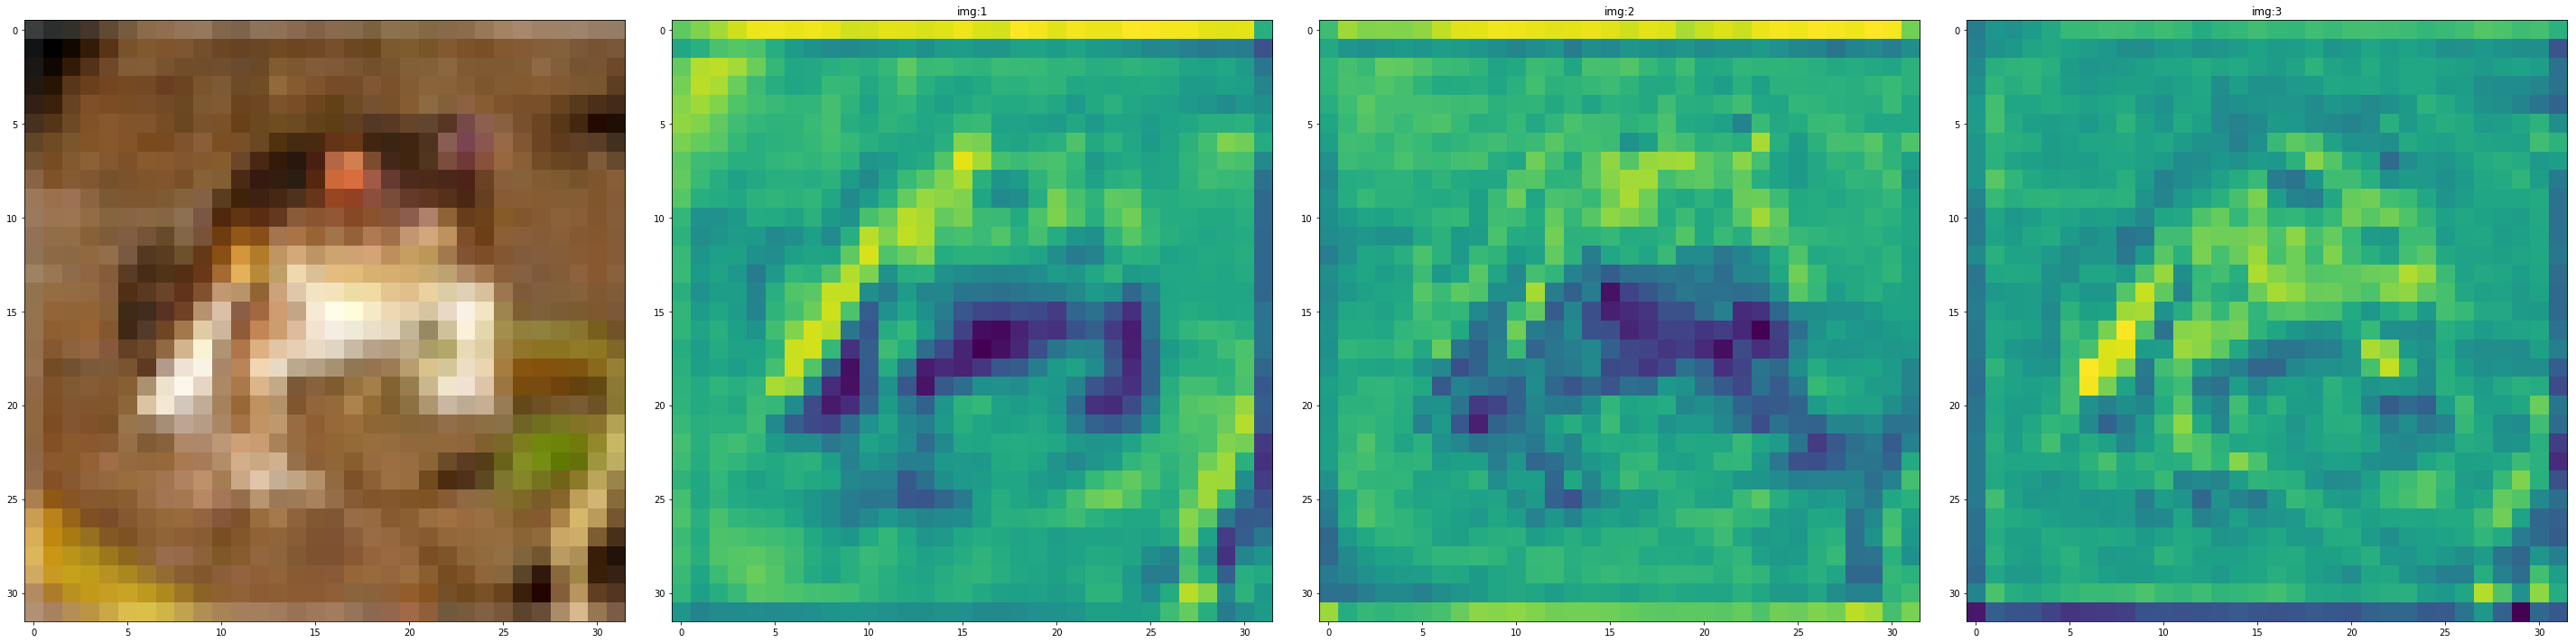

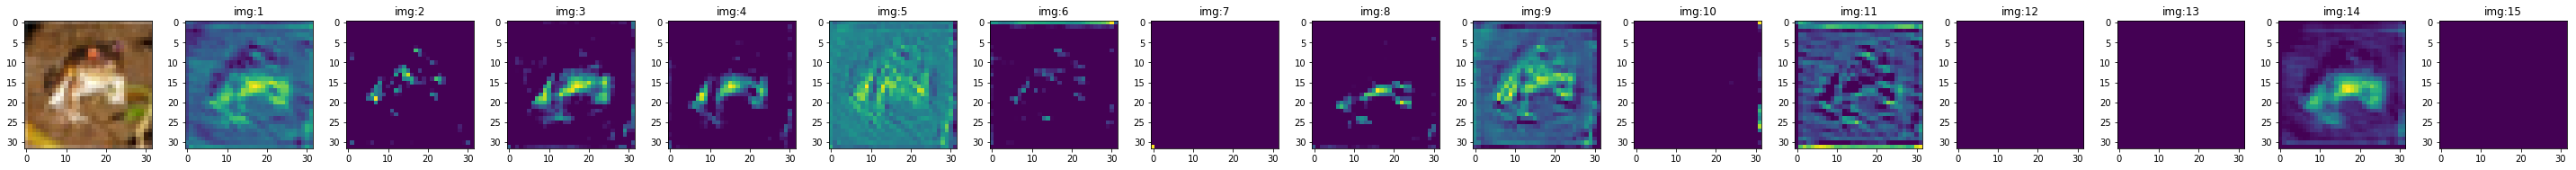

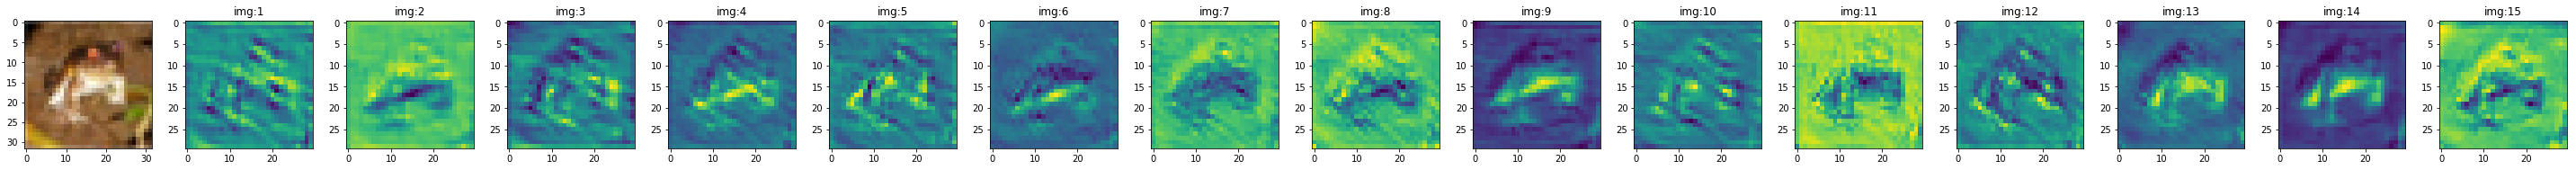

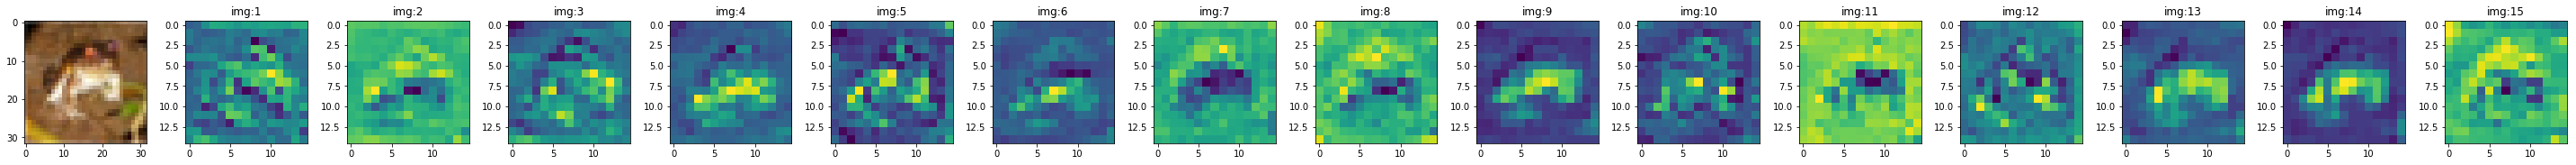

In [10]:
example_out = example_nnicdense(example_train_data[0:3], True)

#get loss
example_loss = example_loss_fn(example_out, example_train_lables[0:100])

#feedback
print('loss:', example_loss.item())

In [11]:
example_out.detach_()
print('example output:', example_out[0])
print('example prediction:', example_out[0].argmax().item())
print('example label:', example_train_lables[0].item())

example output: tensor([ 0.0430,  0.1319, -0.1472,  0.0880, -0.1678, -0.0407,  0.0117, -0.0528,  0.1239, -0.0898])
example prediction: 1
example label: 6


## 3. Training / Optimizer Method

This method will train the model for the specified number of epochs, dividing the batch file into smaller batches.

Note: Splitting the 10,000 image batch helps with memory management.
It may not be necessary for your computer.
To reduce the memory usage per iteration, increase the number the value of `no_subbat`.

This method requires an optimizer and loss function to be defined.

It assumes that the `./cifar-10-batches-py/data_batch_#` files are used.

In [12]:
def train(model, optimizer, loss_fn, epochs, no_subbat = 10, verbose=False) :

    print('epochs:', epochs, 'number of sub batches:', no_subbat, '\n')
    
#     optimizer = torch.optim.Adam(catogorizer.parameters())

#     loss_fn = nn.CrossEntropyLoss()

    start_time = time.time()

    for e in range(epochs) :

        print('epoch:', e + 1, end=' ')

        batno = 0

        for f in [f for f in os.listdir("./cifar-10-batches-py/") if 'data_batch' in f] :

            # get training data
            datset = unpickle(os.path.join("./cifar-10-batches-py",f))
            batlab = torch.tensor(datset[b'labels'])
            batten = torch.tensor(datset[b'data']).float() / 255.
            batten = batten.reshape((10000, 3, 32, 32))

            batno += 1
            subbat_n = 0
            subbat_size = np.floor_divide(len(batten), no_subbat)

            if verbose : print('\nbatch file number:', batno , end=' ')

            for b in range(no_subbat) :

                # forward pass
                out = model.forward(batten[subbat_n * subbat_size : (subbat_n + 1) * subbat_size + subbat_size], False)

                # calculate loss
                loss = loss_fn(out, batlab[subbat_n * subbat_size : (subbat_n + 1) * subbat_size + subbat_size])

                # reset optimizer gradient
                optimizer.zero_grad()

                # backward pass
                loss.backward()

                # increment optimizer
                optimizer.step() 

                # feedback
                if verbose : print(np.round(loss.item(),2), end=', ') 
                else : print('.', end='')
                subbat_n += 1

        # feedback
        print('::> loss:', np.round(loss.item(),2), 'h:', np.round((time.time() - start_time) / 3600), 4)

        batno += 1
        
    # feedback
    run_time = (time.time() - start_time) / 3600
    print('run time (h):', run_time, '\n')

def save_model(model, optimizer, filename='mod') :
    
    # save model
    torch.save(model, filename + '_model.pt')
    print('model saved.')

    # save to resume training later
    state = {'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict()}
    torch.save(state, filename + '_train.pt')
    print('training state saved.')

    # save state for inference
    torch.save(model.state_dict(), filename + '_state.pt')
    print('prediction model saved.')

#### 3.1 Start Training

Similar to what was shown before, instance, train and save the model.

A seperate method `save_model` was defined to save the model , model state, and optimizer state.

In [13]:
nnicdense = imgcatdense()

optimizer = torch.optim.Adam(nnicdense.parameters())
loss_fn = nn.CrossEntropyLoss()

created nerual net:
 imgcatdense(
  (conin): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dens3_15): denseblock(
    (rel): ReLU()
    (conv1): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv3): Conv2d(6, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv4): Conv2d(9, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv5): Conv2d(12, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (mpool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (rel): ReLU()
  (dens15_75): denseblock(
    (rel): ReLU()
    (conv1): Conv2d(15, 15, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(15, 15, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv3): Conv2d(30, 15, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv4): Conv2d(45, 15, kernel_size=(3, 3), stride=(1, 1), 

In [14]:
train(nnicdense, optimizer, loss_fn, epochs=1, no_subbat=50, verbose=True)

save_model(nnicdense, optimizer, 'imgcatdense')

epochs: 1 number of sub batches: 50 

epoch: 1 
batch file number: 1 2.31, 2.3, 2.3, 2.31, 2.31, 2.31, 2.3, 2.3, 2.31, 2.31, 2.31, 2.3, 2.3, 2.3, 2.3, 2.31, 2.3, 2.3, 2.3, 2.31, 2.31, 2.3, 2.3, 2.3, 2.31, 2.31, 2.3, 2.3, 2.3, 2.31, 2.3, 2.31, 2.31, 2.32, 2.31, 2.32, 2.3, 2.31, 2.3, 2.31, 2.31, 2.3, 2.31, 2.31, 2.3, 2.31, 2.31, 2.3, 2.3, 2.31, 
batch file number: 2 2.3, 2.3, 2.3, 2.31, 2.3, 2.31, 2.31, 2.31, 2.32, 2.3, 2.3, 2.3, 2.3, 2.3, 2.3, 2.31, 2.3, 2.3, 2.3, 2.3, 2.31, 2.3, 2.31, 2.31, 2.31, 2.3, 2.3, 2.31, 2.31, 2.31, 2.3, 2.3, 2.3, 2.3, 2.31, 2.3, 2.32, 2.31, 2.3, 2.31, 2.3, 2.3, 2.3, 2.31, 2.31, 2.3, 2.3, 2.3, 2.3, 2.31, 
batch file number: 3 2.31, 2.3, 2.3, 2.3, 2.31, 2.3, 2.3, 2.3, 2.3, 2.3, 2.3, 2.3, 2.3, 2.31, 2.3, 2.3, 2.3, 2.31, 2.3, 2.33, 2.31, 2.3, 2.29, 2.33, 2.3, 2.31, 2.3, 2.3, 2.3, 2.3, 2.3, 2.3, 2.3, 2.3, 2.31, 2.3, 2.3, 2.3, 2.31, 2.29, 2.3, 2.3, 2.31, 2.3, 2.29, 2.3, 2.3, 2.31, 2.29, 2.3, 
batch file number: 4 2.3, 2.31, 2.3, 2.3, 2.31, 2.31, 2.29, 2.31, 2.29, 2.

## 4. Test Method

This method selects a specified random sampling of images in the test data set, makes a prediction, and determines prediciton accuaracy.

In [15]:
def test_rand(model, notests):
    #switch nn to evaluation mode (not training)
    model.eval()

    # get data - unpickle
    testset = unpickle("cifar-10-batches-py/test_batch")
    testlab = torch.tensor(testset[b'labels'])
    testdat = torch.tensor(testset[b'data']).float() / 255.
    testdat = testdat.reshape((10000, 3, 32, 32))

    # get test sub-set image data and labels
    imgs = torch.randint(high=len(testdat), size=(notests,))
    test_mini = testdat[imgs]
    target_mini = testlab[imgs]

    # predict
    out = model(test_mini)

    # analysis and feedback
    pred = out.detach().argmax(dim=1)
    print('prediction:\n', pred, '\ntarget:\n', target_mini)

    acc = (pred - target_mini) == 0
    acc = acc.sum().float() / notests
    print('accuracy:', np.round(acc.item() * 100,2), '%')

In [16]:
test_rand(nnicdense, 25)

prediction:
 tensor([8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]) 
target:
 tensor([7, 3, 8, 2, 7, 8, 0, 1, 4, 0, 7, 1, 0, 9, 4, 8, 8, 4, 0, 2, 7, 3, 6, 5, 4])
accuracy: 16.0 %


# 5. Restore

Assuming the model was trainined and the optimizer and model state were saved, the model can be restored to resume training.

[ https://stackoverflow.com/questions/42703500/best-way-to-save-a-trained-model-in-pytorch ]

In [17]:
restored_model = torch.load('imgcatdense_model.pt')

restored_optimizer = torch.optim.Adam(nnicdense.parameters())
restored_loss_fn = nn.CrossEntropyLoss()

mod_opt_state = torch.load('imgcatdense_train.pt')
restored_model.load_state_dict(mod_opt_state['model_state_dict'])
restored_optimizer.load_state_dict(mod_opt_state['optimizer_state_dict'])

In [18]:
# --- continue training
train(restored_model, restored_optimizer, restored_loss_fn, epochs=1, no_subbat=100, verbose=False)

epochs: 1 number of sub batches: 100 

epoch: 1 ....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................::> loss: 2.29 h: 0.0 4
run time (h): 0.40476590123441486 



Note: Training was only allowed to be one epoch to illustrate usage. It is reccommended to train this model on a high performance computer. 